In [1]:
import matplotlib.pyplot as plt


import torch
from torch import nn
from torch import optim
from tqdm import trange
from torch.utils.data import DataLoader
from data import PermutedMNIST
from utils import EWC, train, test


In [2]:
epochs = 50
lr = 1e-3
batch_size = 128
sample_size = 200
hidden_size = 200
num_task = 3
importance = 1000


In [3]:
class MLP(nn.Module):
    def __init__(self, hidden_size: int = 400):
        super().__init__()
        self.layers = nn.Sequential(
            nn.Linear(28 * 28, hidden_size),
            nn.ReLU(inplace=True),
            nn.Linear(hidden_size, hidden_size),
            nn.ReLU(inplace=True),
            nn.Linear(hidden_size, hidden_size),
            nn.ReLU(inplace=True),
            nn.Linear(hidden_size, 10),
            nn.ReLU(inplace=True),
        )

    def forward(self, input):
        return self.layers(input)


In [4]:
train_loader: dict[int, DataLoader] = {}
test_dataset: dict[int, PermutedMNIST] = {}

for i in range(num_task):
    idx = torch.randperm(28 * 28)
    train_loader[i] = DataLoader(
        PermutedMNIST(train=True, permute_idx=idx),
        batch_size,
        num_workers=8,
        persistent_workers=True,
    )
    test_dataset[i] = PermutedMNIST(train=False, permute_idx=idx)


In [5]:
def process(epochs: int, use_ewc: bool):
    model = MLP(hidden_size).cuda()
    optimizer = optim.SGD(params=model.parameters(), lr=lr)

    loss: dict[int, list[float]] = {task: [] for task in range(num_task)}
    acc: dict[int, list[float]] = {task: [] for task in range(num_task)}
    for _ in trange(2 * epochs):
        loss[0].append(train(model, optimizer, train_loader[0]))
        acc[0].append(test(model, test_dataset[0]))

    for task in range(1 + num_task):
        if use_ewc:
            old_tasks = []
            for previous_task in range(task):
                dataset = train_loader[previous_task].dataset
                assert isinstance(dataset, PermutedMNIST)
                old_tasks += dataset.get_sample(sample_size // task)
            old_tasks = torch.vstack(old_tasks)
            ewc = EWC(model, old_tasks)
        else:
            ewc = None

        for _ in trange(epochs):
            loss[task].append(
                train(
                    model,
                    optimizer,
                    train_loader[task],
                    ewc,
                    importance,
                )
            )
            for previous_task in range(task + 1):
                acc[previous_task].append(test(model, test_dataset[previous_task]))

    return loss, acc


In [22]:
import matplotlib.ticker as mtick


def plot(loss: dict[int, list[float]], acc: dict[int, list[float]]):
    fig, ax = plt.subplots(2, figsize=(5, 6), sharex=True)
    for t, v in loss.items():
        ax[0].plot(list(range(t * epochs, (t + 1) * epochs)), v, label=f"Task {t}")
    for t, v in acc.items():
        ax[1].plot(list(range(t * epochs, num_task * epochs)), v, label=f"Task {t}")
    ax[0].set(ylabel="Loss")
    ax[1].set(ylabel="Accuracy", ylim=(0, 1), xlabel="Epochs")
    ax[0].legend()
    ax[1].grid(color="gray", linestyle=":")
    ax[1].yaxis.set_major_formatter(mtick.PercentFormatter(1))
    fig.tight_layout()


In [15]:
loss, acc = process(epochs, use_ewc=False)


  0%|          | 0/50 [00:00<?, ?it/s]

100%|██████████| 50/50 [00:34<00:00,  1.46it/s]


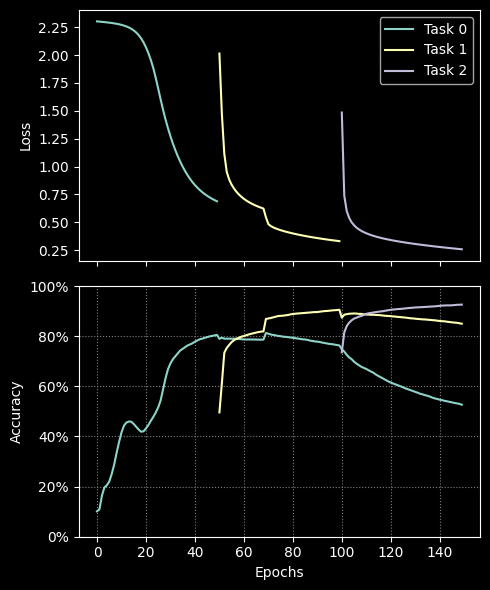

In [23]:
plot(loss, acc)


In [29]:
loss_ewc, acc_ewc = process(epochs, use_ewc=True)


  0%|          | 0/50 [00:00<?, ?it/s]

100%|██████████| 50/50 [00:54<00:00,  1.09s/it]


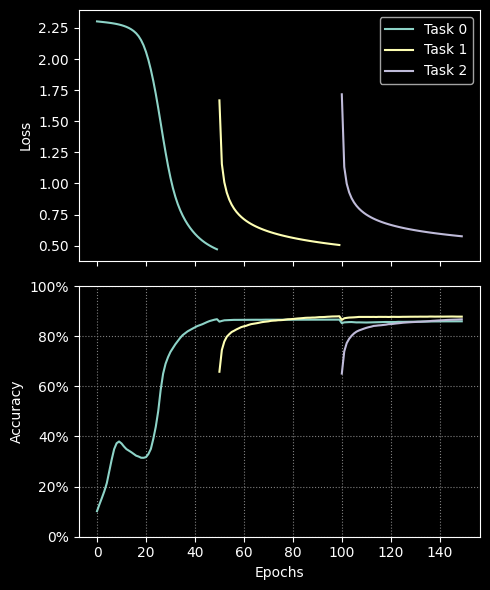

In [30]:
plot(loss_ewc, acc_ewc)


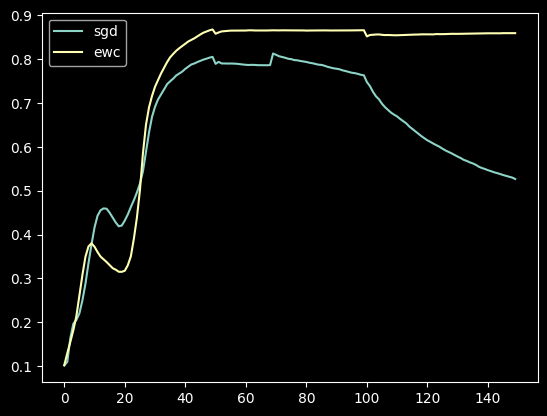

In [31]:
plt.plot(acc[0], label="sgd")
plt.plot(acc_ewc[0], label="ewc")
plt.legend()
